<a href="https://colab.research.google.com/github/behdad13/time-series-forecasting/blob/main/2D_CNN_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importing necessary libraries 

In [2]:
#installing necessary libraries
!pip install torch
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 20.1 MB/s 
     |████████████████████████████████| 81 kB 11.3 MB/s 
     |████████████████████████████████| 210 kB 82.3 MB/s 
     |████████████████████████████████| 78 kB 9.7 MB/s 
     |████████████████████████████████| 147 kB 68.3 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
     |████████████████████████████████| 112 kB 75.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=bf697034adb233d5d80587d4b9d2333dede7ee6030c13d9259a2966749e44a0a
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Unin

In [3]:
#import necessary libraries
import os
import random
import time
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import array
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.trial import TrialState
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
#set seed
seed_val = 67
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## importing pre-processed dataset

In [5]:
#import the dataset
data = pd.read_csv('Data_Toronto.csv', low_memory=False)

#select the most relevent feature from the dataset
data = data[['Year', 'Month', 'Day', 'Hour', 'week_end','temperature', 'humidex', 'Ontario_Real_price', 'Electricity_Load']]

In [6]:
#define the test and train set
seq = 5*24
horizon = 24
train = data.iloc[17520+8760+8786 - seq : 43824 + horizon]
test = data.iloc[43824 - seq : 43824+30*24 + horizon]

## train-val-test split

In [7]:
#defining the training proportion
#seperating train and validation set
train_size = int(len(data)*0.80)      
valid_size = int(len(data)*0.20)
df_train, df_val = data[:train_size], data[train_size+1:]
df_train.shape, df_val.shape, test.shape

((38534, 9), (9633, 9), (864, 9))

In [8]:
# scaling each features of the dataset
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train),index = df_train.index, columns = df_train.columns)
df_val = pd.DataFrame(scaler.transform(df_val),index = df_val.index, columns = df_val.columns)
test = pd.DataFrame(scaler.transform(test),index = test.index, columns = test.columns)

## Make a time sequneces

In [9]:
df_train = df_train.to_numpy()
df_val = df_val.to_numpy()
test = test.to_numpy()

In [10]:
# split a multivariate sequence into samples
from numpy import array
def split_sequences(sequences, n_steps, for_hor):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-for_hor:
            break
        # gather input and output parts of the pattern
        # sequence_x ranges from 0 to seq_len and all columns except the last one.
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:end_ix+for_hor, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [11]:
n_timesteps = 24*5
for_hor = 24
X_train, y_train = split_sequences(df_train, n_timesteps, for_hor)
X_val, y_val = split_sequences(df_val, n_timesteps, for_hor)
X_test, y_test = split_sequences(test, n_timesteps, for_hor)

In [12]:
print(X_test.shape, y_test.shape)

(721, 120, 9) (721, 24)


In [13]:
n_timesteps + len(X_train) + for_hor-1 == len(df_train)

True

 ## Data Loader

In [14]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 64


X_train_t = torch.Tensor(X_train)
y_train_t = torch.Tensor(y_train)
X_val_t = torch.Tensor(X_val)
y_val_t = torch.Tensor(y_val)
X_test_t = torch.Tensor(X_test)
y_test_t = torch.Tensor(y_test)

train = TensorDataset(X_train_t, y_train_t)
val = TensorDataset(X_val_t, y_val_t)
test_w1 = TensorDataset(X_test_t, y_test_t)


train_loader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle = False, drop_last=True)
test_loader_one_w1 = DataLoader(test_w1, batch_size=1, shuffle = False, drop_last=True)

In [15]:
#check the size of the train set
X_train_t.shape, y_train_t.shape

(torch.Size([38391, 120, 9]), torch.Size([38391, 24]))

In [16]:
#just for testing the size of the batch
next(iter(train_loader))[1].size(), next(iter(train_loader))[0].size()

(torch.Size([64, 24]), torch.Size([64, 120, 9]))

## deep learning model

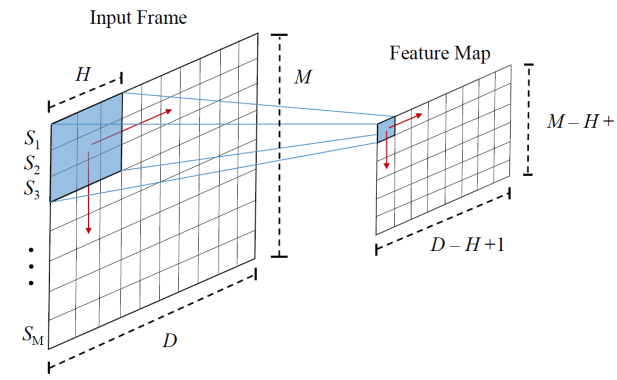

S respresents the features and D shows the sequence length.

* There is a small difference between the code and the model proposed in https://www.mdpi.com/1996-1073/14/9/2392. I use a padding layer to conserve the initial dimension of the Conv2d.

Here is the code of a CNN-2D without a LSTM layer. 

In [18]:
class CNN2D(nn.Module):
    def __init__(self, out_channel1=5, kernel_size_h=2, kernel_size_w=3, c_out=24, c_in=9, seq_len=120):
        super(CNN2D, self).__init__()
        
        self.pad1= torch.nn.ConstantPad2d((kernel_size_w-1,0,kernel_size_h-1,0), 0)

        self.layer1_1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, out_channel1, kernel_size=(kernel_size_h, kernel_size_w), stride=1, padding=0),
            torch.nn.ReLU())
        
        self.linear1 = nn.Linear(out_channel1*c_in*seq_len, c_out)


    def forward(self, x):
        x = torch.unsqueeze(x, 3)
        x = x.permute(0,3,1,2)
        out1 = self.pad1(x)        
        out1 = self.layer1_1(out1)
        out1 = out1.permute(0,2,1,3)
        out1 = torch.flatten(out1, start_dim=1)
        out = self.linear1(out1)
        return out

The proposed structure represents a **hybrid parallel 2D-CNN-LSTM** for time-series forecasting.

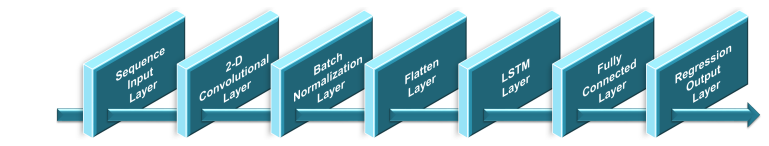

* Batch-normalization is not considered in the code

In [19]:
class CNNLSTM2D(nn.Module):
    def __init__(self, out_channel1=5, kernel_size_h=2, kernel_size_w=3, hidden_layer = 64, c_out=24, c_in=9, seq_len=120):
        super(CNNLSTM2D, self).__init__()
        
        self.pad1= torch.nn.ConstantPad2d((kernel_size_w-1,0,kernel_size_h-1,0), 0)

        self.layer1_1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, out_channel1, kernel_size=(kernel_size_h, kernel_size_w), stride=1, padding=0),
            torch.nn.ReLU())
        
        self.layer1_2 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 10, kernel_size=(1, 5), stride=1, padding=0),
            torch.nn.ReLU())
        
        self.lstm = nn.LSTM(out_channel1*c_in, hidden_layer)
        self.linear1 = nn.Linear(hidden_layer*seq_len, c_out)


    def forward(self, x):
        x = torch.unsqueeze(x, 3)                 # add an extra dimension as an input number of channel (equals 1)
        x = x.permute(0,3,1,2)                    # change the shape --> [batch_size, in_channel, in_feature, seq_len]
        out1 = self.pad1(x)                       # add a padding layer to conserve the initial shape (optional)
        out1 = self.layer1_1(out1)                # add Conv2d and Relu
        out1 = out1.permute(0,2,1,3)              # reshape it to --> [batch_size, in_feature, in_channel, seq_len]
        out1 = torch.flatten(out1, start_dim=2)    # change the shape --> [batch_size, in_feature, in_channel * seq_len] for feeding a lstm layer
        out, (_, _)= self.lstm(out1)              # add LSTM layer 
        out = torch.flatten(out, start_dim=1)      # change the shape --> [batch_size, in_feature * in_channel * seq_len] for feeding a linear layer
        out = self.linear1(out)                   # add linear layer
        return out

In [20]:
#just for checking the dimensions
x = torch.rand(64, 120, 9)

model = CNNLSTM2D()

y= model(x)
y.shape

torch.Size([64, 24])

In [21]:
#defining an objective function of the bayesian Optimization and which parameters need to be tuned
epochs = 250 
patience = 20
loss = nn.MSELoss()
min_val_loss_total=np.inf

def objective(trial):
    #define the infinity variable
    min_val_loss = np.inf
    
    
    # Generate the model.
    model = CNNLSTM2D(out_channel1=trial.suggest_int("channel", 2, 64), 
                hidden_layer=trial.suggest_int("hidden", 16, 128), 
                kernel_size_h=trial.suggest_int("kh1", 1, 5), 
                kernel_size_w=trial.suggest_int("kw1", 1, 5), 
                c_out=24, 
                c_in=9, 
                seq_len=120).cuda() 


    # Generate the optimizers.
    loss_fn = nn.MSELoss() 
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Training of the model.
    counter = 0
    for i in range(epochs):
        mse_train = 0
        iteration_start = time.monotonic()
        for batch_x, batch_y in train_loader :
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            y_pred = model(batch_x)
            y_pred = y_pred.squeeze(1)
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()
        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                output = model(batch_x)
                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        if min_val_loss > mse_val:
            min_val_loss = mse_val
            counter = 0
        else: 
            counter += 1
        if counter == patience:
            break   

        global min_val_loss_total
        if min_val_loss_total > mse_val:
            min_val_loss_total = mse_val
            torch.save(model.state_dict(), "CNNLSTM2D.pt")


        if i % 20 == 0:
            print("Iter: ", i, "train: ", (mse_train), "val: ", (mse_val))
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        trial.report(min_val_loss, i)

    return min_val_loss

In [22]:
if __name__ == "__main__":
    #create the study
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

    #calling the optimzation process
    study.optimize(objective, n_trials=5)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    #with open("CNN.pickle".format(study.best_trial.number), "rb") as fin:
    #    best_clf = pickle.load(fin)

[I 2022-12-29 15:42:36,683] A new study created in memory with name: no-name-24aba13d-236a-4b86-bd26-d4bc190b3e4f


Iter:  0 train:  844.8169253468513 val:  116.89691773056984
Iter:  20 train:  85.45173873752356 val:  40.40077205747366
Iter:  40 train:  71.71828713268042 val:  29.10344386845827
Iter:  60 train:  64.14627539739013 val:  24.691121384501457
Iter:  80 train:  59.42051484063268 val:  21.85826339945197
Iter:  100 train:  57.224231481552124 val:  22.771257005631924
Iter:  120 train:  54.794378861784935 val:  21.192114090546966
Iter:  140 train:  53.065155416727066 val:  21.40712638758123


[I 2022-12-29 15:48:54,245] Trial 0 finished with value: 20.907539882697165 and parameters: {'channel': 46, 'hidden': 29, 'kh1': 2, 'kw1': 2, 'lr': 2.4660119074279514e-05}. Best is trial 0 with value: 20.907539882697165.


Iter:  0 train:  438.34415720403194 val:  75.09012451022863
Iter:  20 train:  58.63777120783925 val:  24.33190070092678
Iter:  40 train:  46.82669824361801 val:  22.492550656199455


[I 2022-12-29 15:52:13,581] Trial 1 finished with value: 22.29193569160998 and parameters: {'channel': 48, 'hidden': 83, 'kh1': 2, 'kw1': 5, 'lr': 5.8302839382861244e-05}. Best is trial 0 with value: 20.907539882697165.


Iter:  0 train:  944.8997507691383 val:  115.66236661374569
Iter:  20 train:  98.05107122659683 val:  31.720079811289907
Iter:  40 train:  79.72570177167654 val:  26.987814132124186
Iter:  60 train:  71.88124735280871 val:  25.323684249073267
Iter:  80 train:  66.68010395020247 val:  24.401690861210227
Iter:  100 train:  63.46690293028951 val:  23.396957403048873
Iter:  120 train:  60.88191430270672 val:  23.478789445012808


[I 2022-12-29 15:57:40,197] Trial 2 finished with value: 22.12722342647612 and parameters: {'channel': 22, 'hidden': 54, 'kh1': 1, 'kw1': 5, 'lr': 1.5617689841641967e-05}. Best is trial 0 with value: 20.907539882697165.


Iter:  0 train:  1123.3340548276901 val:  188.06676524877548
Iter:  20 train:  119.32138361781836 val:  42.095075538381934
Iter:  40 train:  96.20274955034256 val:  35.875097043812275
Iter:  60 train:  86.21754845231771 val:  31.24198483861983
Iter:  80 train:  79.89236518740654 val:  29.489824442192912
Iter:  100 train:  75.51412994414568 val:  28.37076063081622
Iter:  120 train:  72.51350338757038 val:  29.340551763772964
Iter:  140 train:  70.44204033538699 val:  28.568240094929934
Iter:  160 train:  68.4943694844842 val:  26.637438317760825
Iter:  180 train:  67.36812536418438 val:  26.290546813048422
Iter:  200 train:  66.15600521117449 val:  26.300217581912875
Iter:  220 train:  65.24344205856323 val:  26.864914862439036


[I 2022-12-29 16:05:31,848] Trial 3 finished with value: 25.148267678916454 and parameters: {'channel': 11, 'hidden': 24, 'kh1': 5, 'kw1': 5, 'lr': 1.3881798494119537e-05}. Best is trial 0 with value: 20.907539882697165.


Iter:  0 train:  211.05128902196884 val:  32.84254878014326
Iter:  20 train:  40.42799298092723 val:  35.445200947113335


[I 2022-12-29 16:07:03,950] Trial 4 finished with value: 22.344801384955645 and parameters: {'channel': 15, 'hidden': 98, 'kh1': 5, 'kw1': 4, 'lr': 0.0006568612019564686}. Best is trial 0 with value: 20.907539882697165.


Study statistics: 
  Number of finished trials:  5
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  20.907539882697165
  Params: 
    channel: 46
    hidden: 29
    kh1: 2
    kw1: 2
    lr: 2.4660119074279514e-05


<ipython-input-23-49e97b30e6a9>:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["channel", 'hidden', "kw1", "kh1", "lr" ])


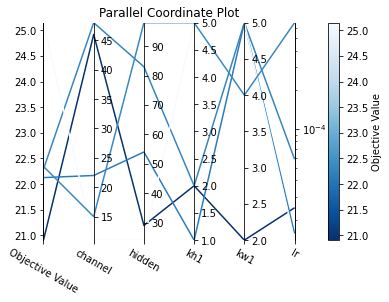

In [23]:
#Visualizing sets of tunned yperparameters based on the BO
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["channel", 'hidden', "kw1", "kh1", "lr" ])
optuna.visualization.plot_param_importances(study)

In [ ]:
#Download the PT file
from google.colab import files
files.download('CNNLSTM2D.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
#Read the pk file
model = CNNLSTM2D(out_channel1=46, 
                kernel_size_h=2, 
                kernel_size_w=2, 
                hidden_layer=29,
                c_out=24, 
                c_in=9, 
                seq_len=120).cuda()

model.load_state_dict(torch.load("CNNLSTM2D.pt"))

<All keys matched successfully>

In [26]:
#call a desacaler function for the further analysis
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [28]:
# the error calculation function
def calculate_metrics(values_descaled, prediction_descaled):
    result_metrics = {
                      'MAE' : mean_absolute_error(values_descaled, prediction_descaled),
                      'MSE' : mean_squared_error(values_descaled, prediction_descaled),
                      'R2'  : r2_score(values_descaled, prediction_descaled),
                      'MAPE': mean_absolute_percentage_error(values_descaled, prediction_descaled)
                      }
    print("Root Mean Squared Error :  ", result_metrics["MSE"]**0.5)
    print("R^2                :       ", result_metrics["R2"])
    print("Mean Absolute Error:       ", result_metrics["MAE"])
    print("MAPE               :       ", result_metrics["MAPE"])
    
    return result_metrics

Test set results

In [29]:
# feeding the model with the test set.
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader_one_w1:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
preds = np.concatenate(preds)
true = np.concatenate(true)

Illustration of one-step, two-step, three-step, and 24-step ahead forecasting

error for next 1 hour prediction
Root Mean Squared Error :   109.54843730949679
R^2                :        0.9789140590029031
Mean Absolute Error:        84.5933798950026
MAPE               :        0.014940777977524786


error for next 2 hour prediction
Root Mean Squared Error :   132.6125929658916
R^2                :        0.9690934876545675
Mean Absolute Error:        101.58136688951977
MAPE               :        0.017939706603284495


error for next 3 hour prediction
Root Mean Squared Error :   155.1589277850159
R^2                :        0.9593926599108945
Mean Absolute Error:        115.97587545238818
MAPE               :        0.020658792982584703


error for next 24 hour prediction
Root Mean Squared Error :   225.04628174371044
R^2                :        0.8944203537518565
Mean Absolute Error:        183.5560653199766
MAPE               :        0.0308670467956804


1-step ahead forecast
2-step ahead forecast
3-step ahead forecast
24-step ahead forecast


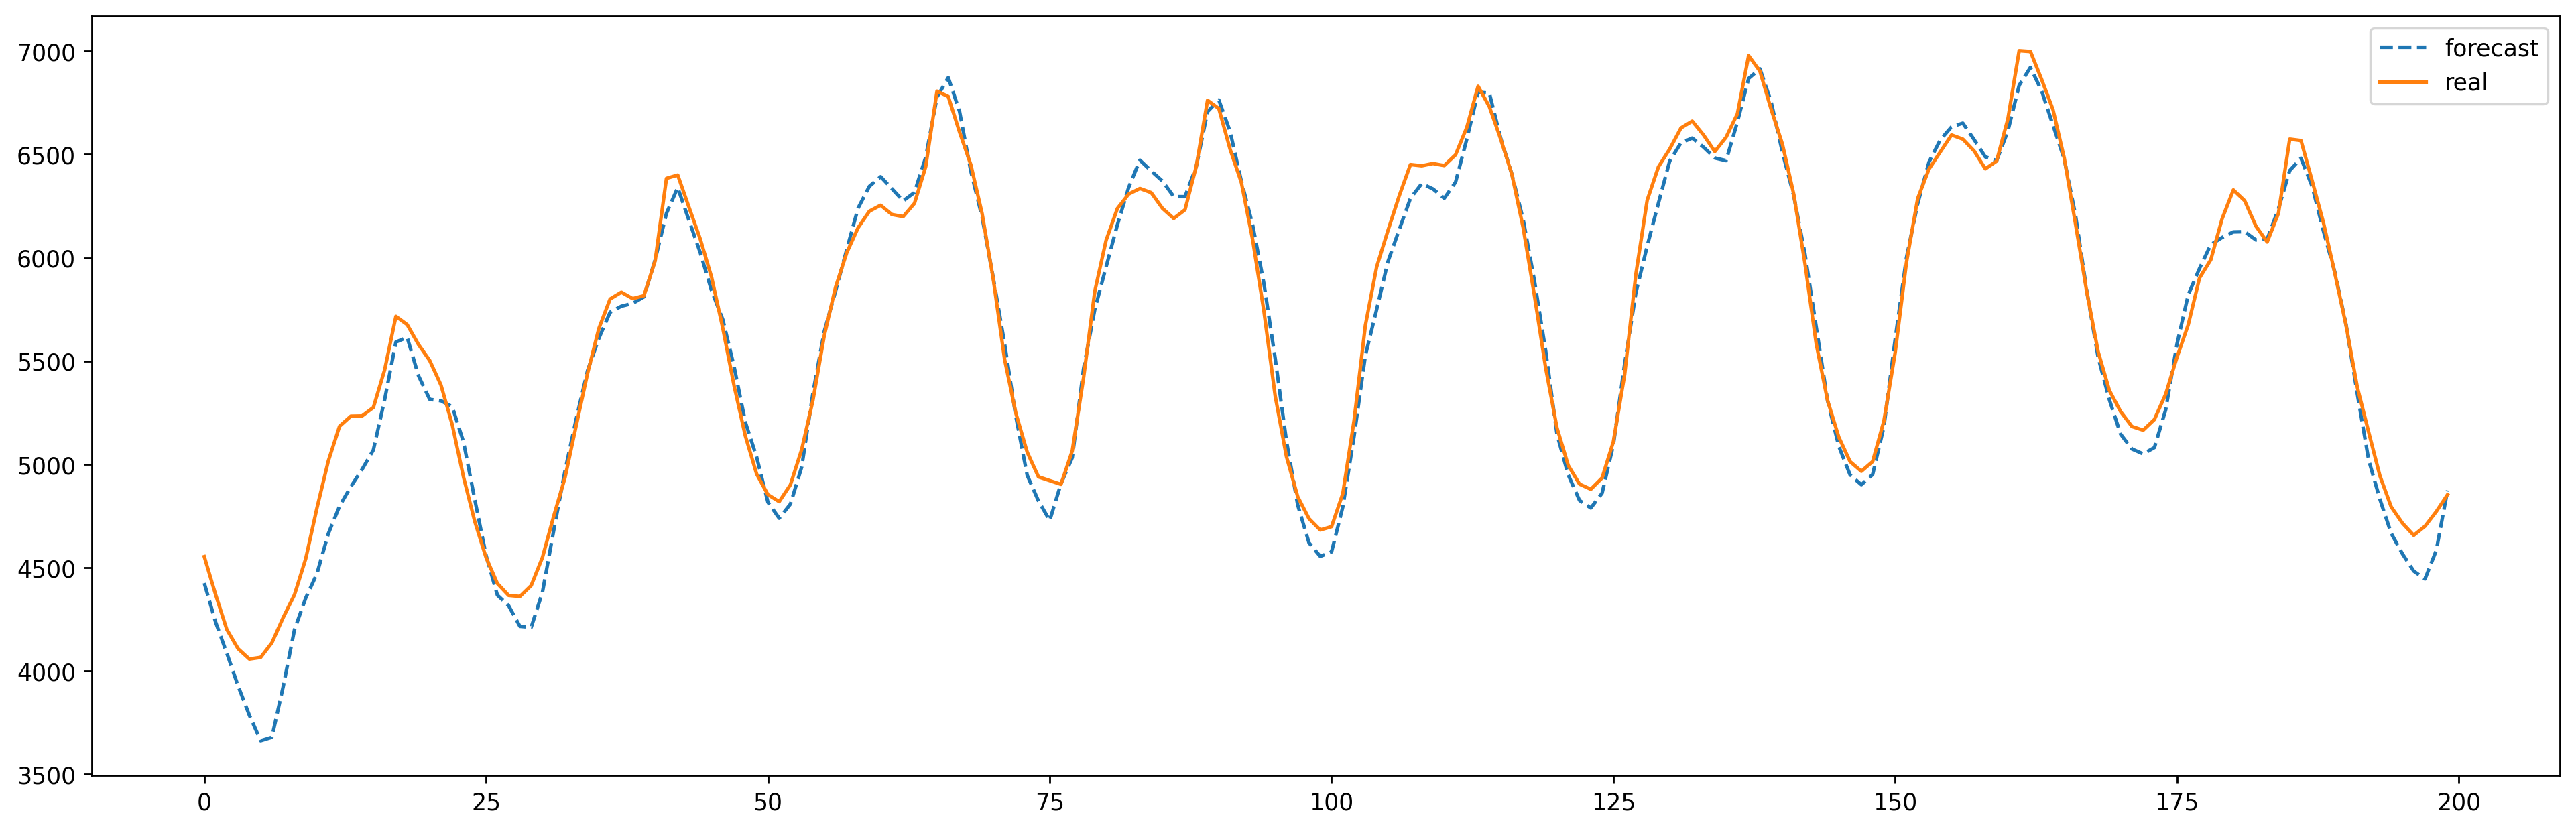

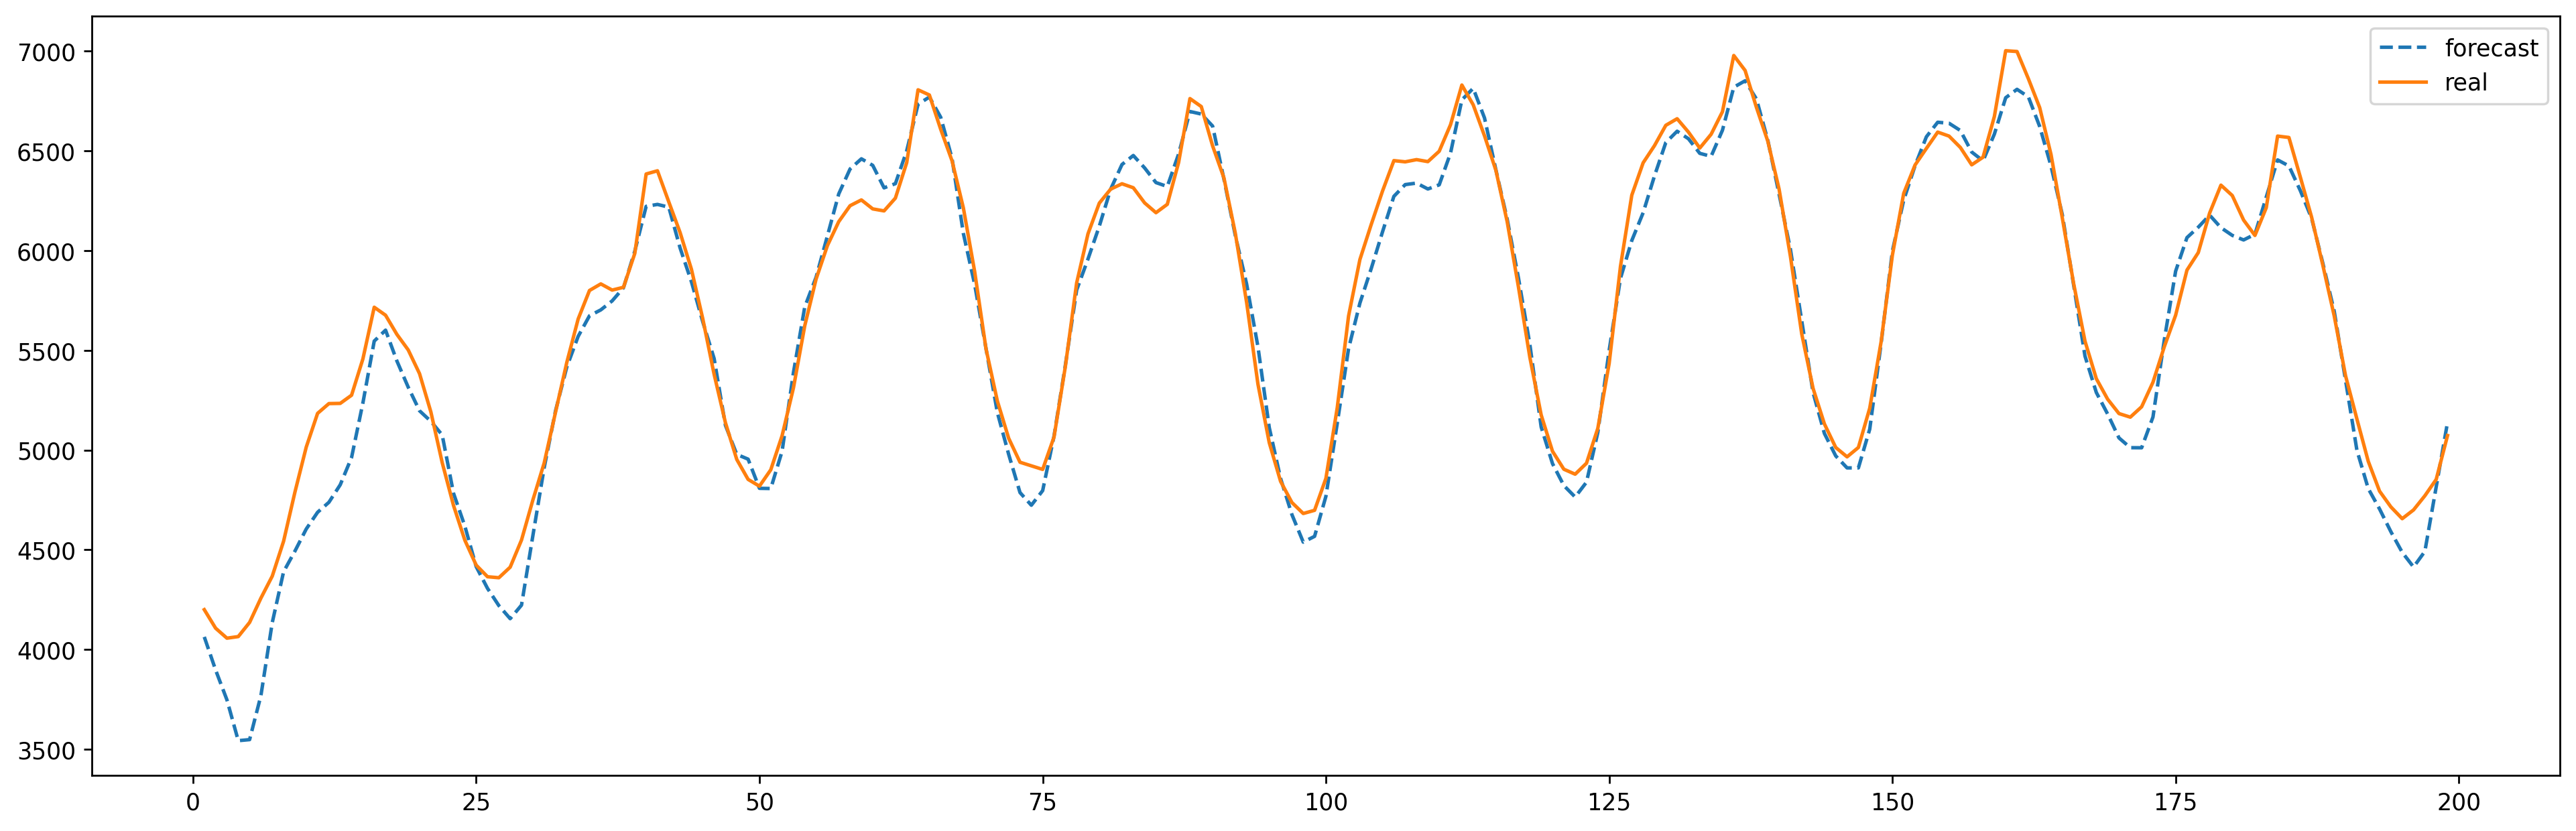

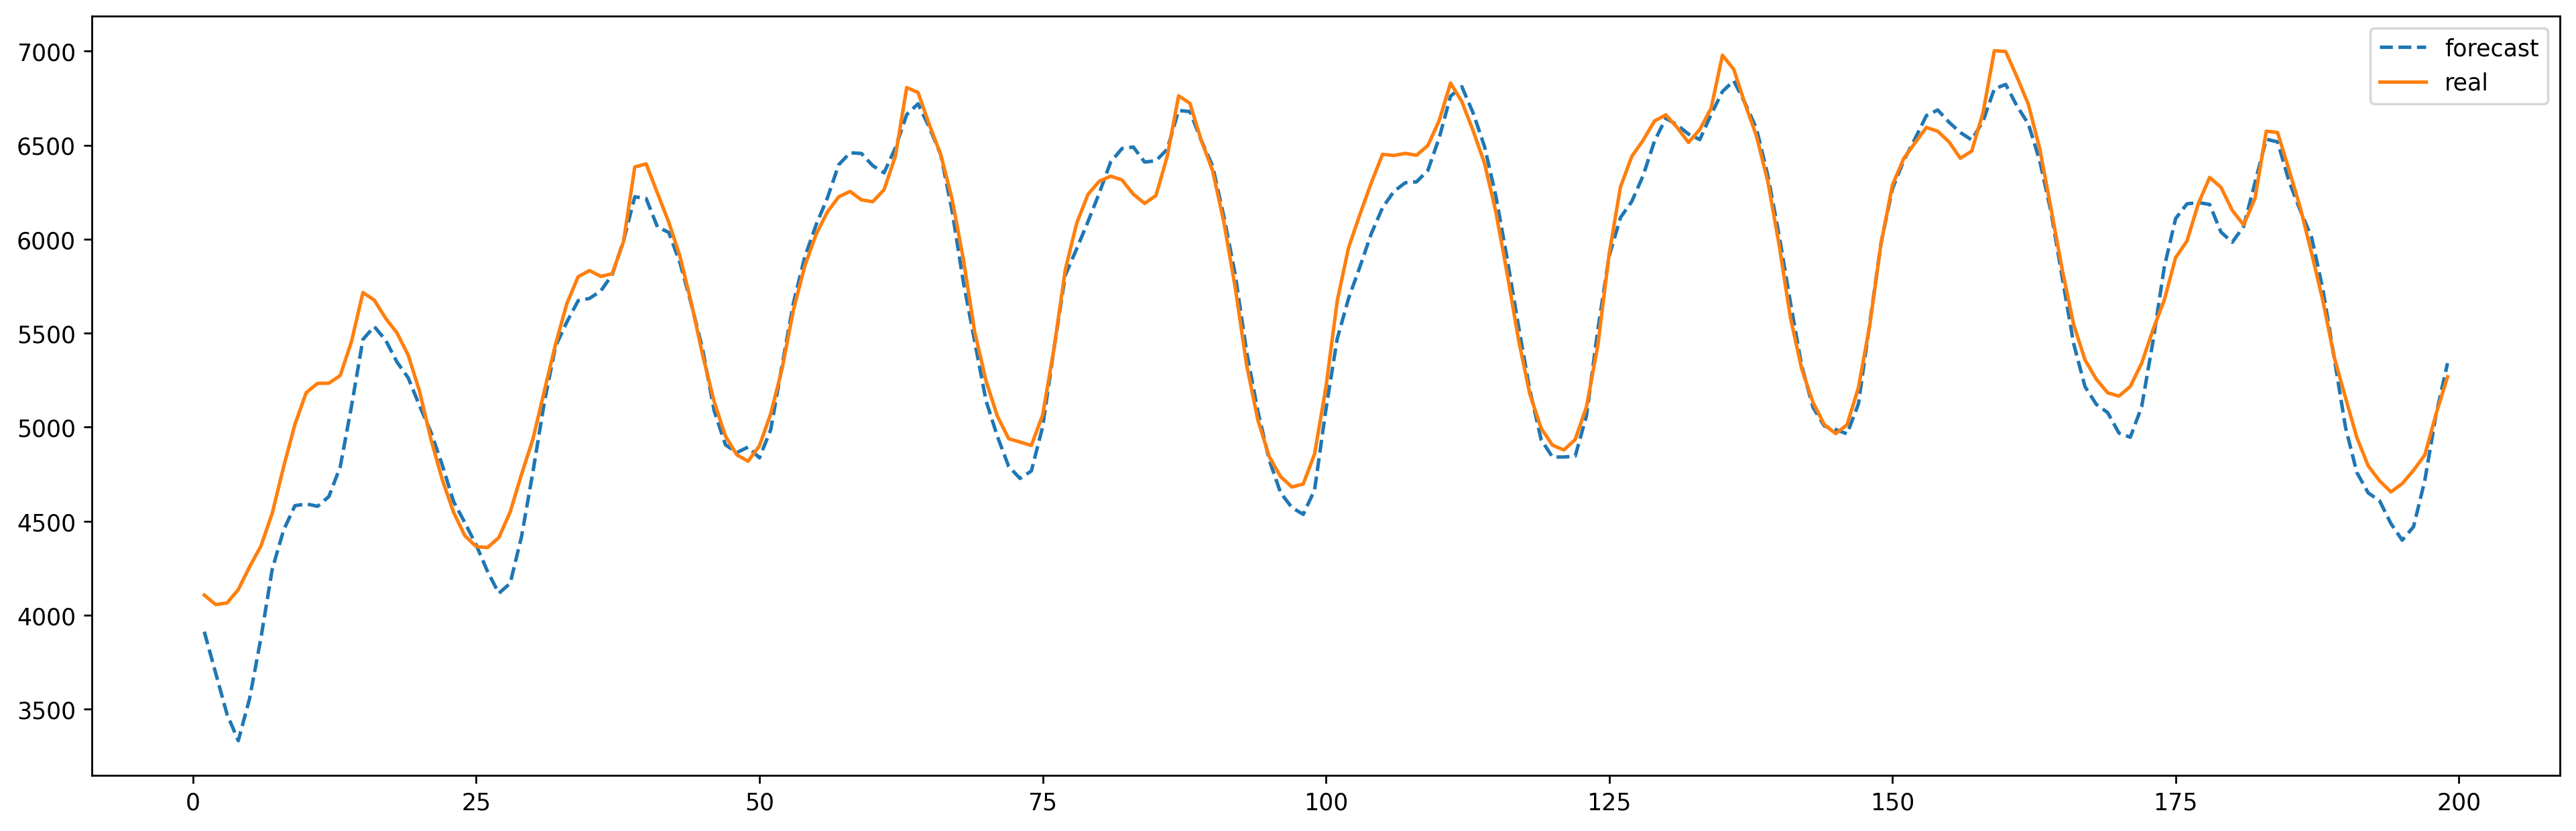

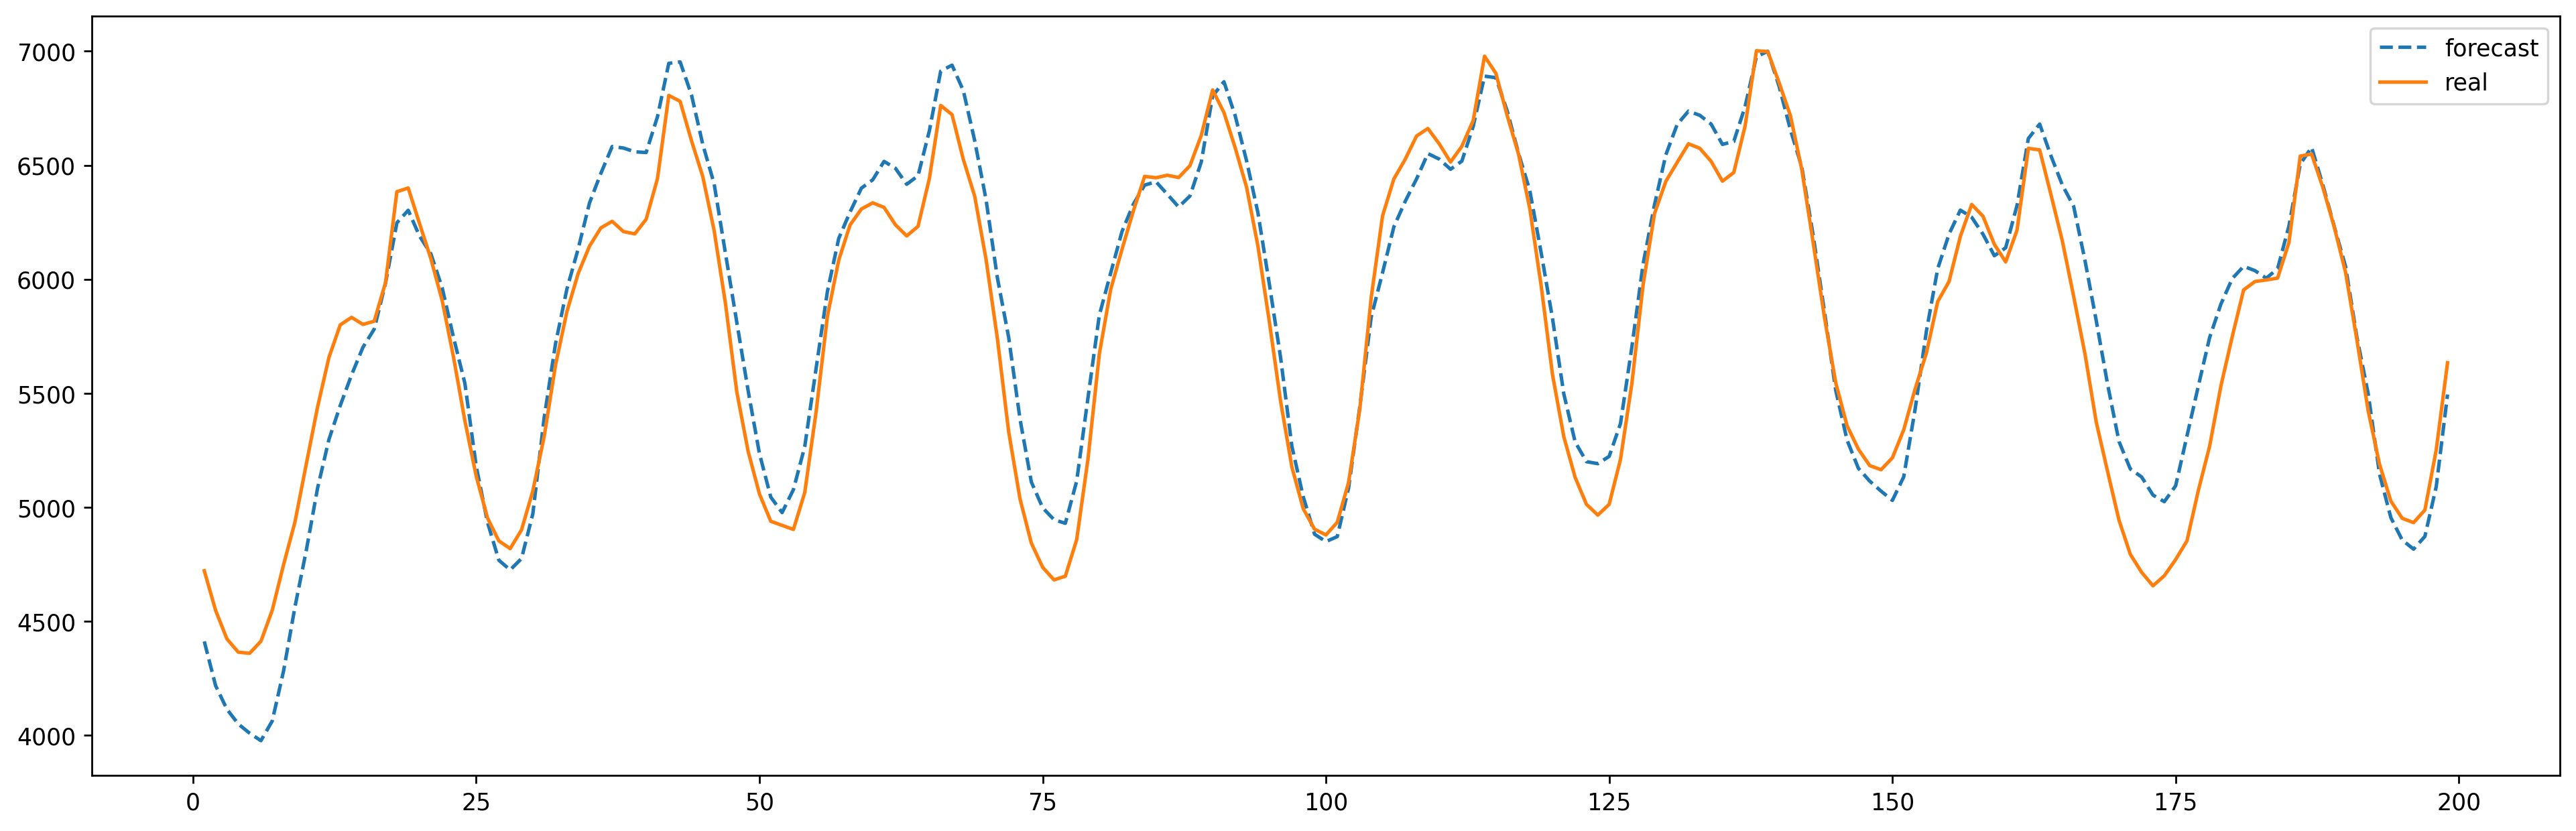

In [30]:
# create an empty dataframe  
df = pd.DataFrame()
df['forcasted_demand_1h'] = 0
df['forcasted_demand_2h'] = 0
df['forcasted_demand_3h'] = 0
df['forcasted_demand_24h'] = 0
df['real_demand_1h'] = 0
df['real_demand_2h'] = 0
df['real_demand_3h'] = 0
df['real_demand_24h'] = 0

for i in range(len(preds)):
    prediction_descaled=[]
    values_descaled=[]
    prediction_descaled = descale(descaler, preds[[i]].reshape(-1))
    values_descaled = descale(descaler, true[[i]].reshape(-1))
    new_row = {'forcasted_demand_1h':prediction_descaled[0], 
           'forcasted_demand_2h':prediction_descaled[1], 
           'forcasted_demand_3h':prediction_descaled[2],
           'forcasted_demand_24h':prediction_descaled[23],
           'real_demand_1h' : values_descaled[0],
           'real_demand_2h' : values_descaled[1],
           'real_demand_3h' : values_descaled[2],
           'real_demand_24h' : values_descaled[23]}
    
    df = df.append(new_row, ignore_index=True)

print('error for next 1 hour prediction')
error_1h = calculate_metrics(df.forcasted_demand_1h,df.real_demand_1h )
print("\n")
print('error for next 2 hour prediction')
error_2h = calculate_metrics(df.forcasted_demand_2h,df.real_demand_2h )
print("\n")
print('error for next 3 hour prediction')
error_3h = calculate_metrics(df.forcasted_demand_3h,df.real_demand_3h )
print("\n")
print('error for next 24 hour prediction')
error_24h = calculate_metrics(df.forcasted_demand_24h,df.real_demand_24h )
print("\n")



print('1-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[0:200], df.forcasted_demand_1h[0:200], "--", label="forecast")
plt.plot(dates[0:200], df.real_demand_1h[0:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('2-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[1:200], df.forcasted_demand_2h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_2h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('3-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_3h))
plt.plot(dates[1:200], df.forcasted_demand_3h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_3h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();


print('24-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_24h))
plt.plot(dates[1:200], df.forcasted_demand_24h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_24h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

Visualizing the series (the next 24-hour forecast for a specific day)

In [31]:
prediction_descaled=[]
values_descaled=[]
for i in range(len(preds)):
    prediction_descaled.append(descale(descaler, preds[[i]].reshape(-1)))
    values_descaled.append(descale(descaler, true[[i]].reshape(-1)))

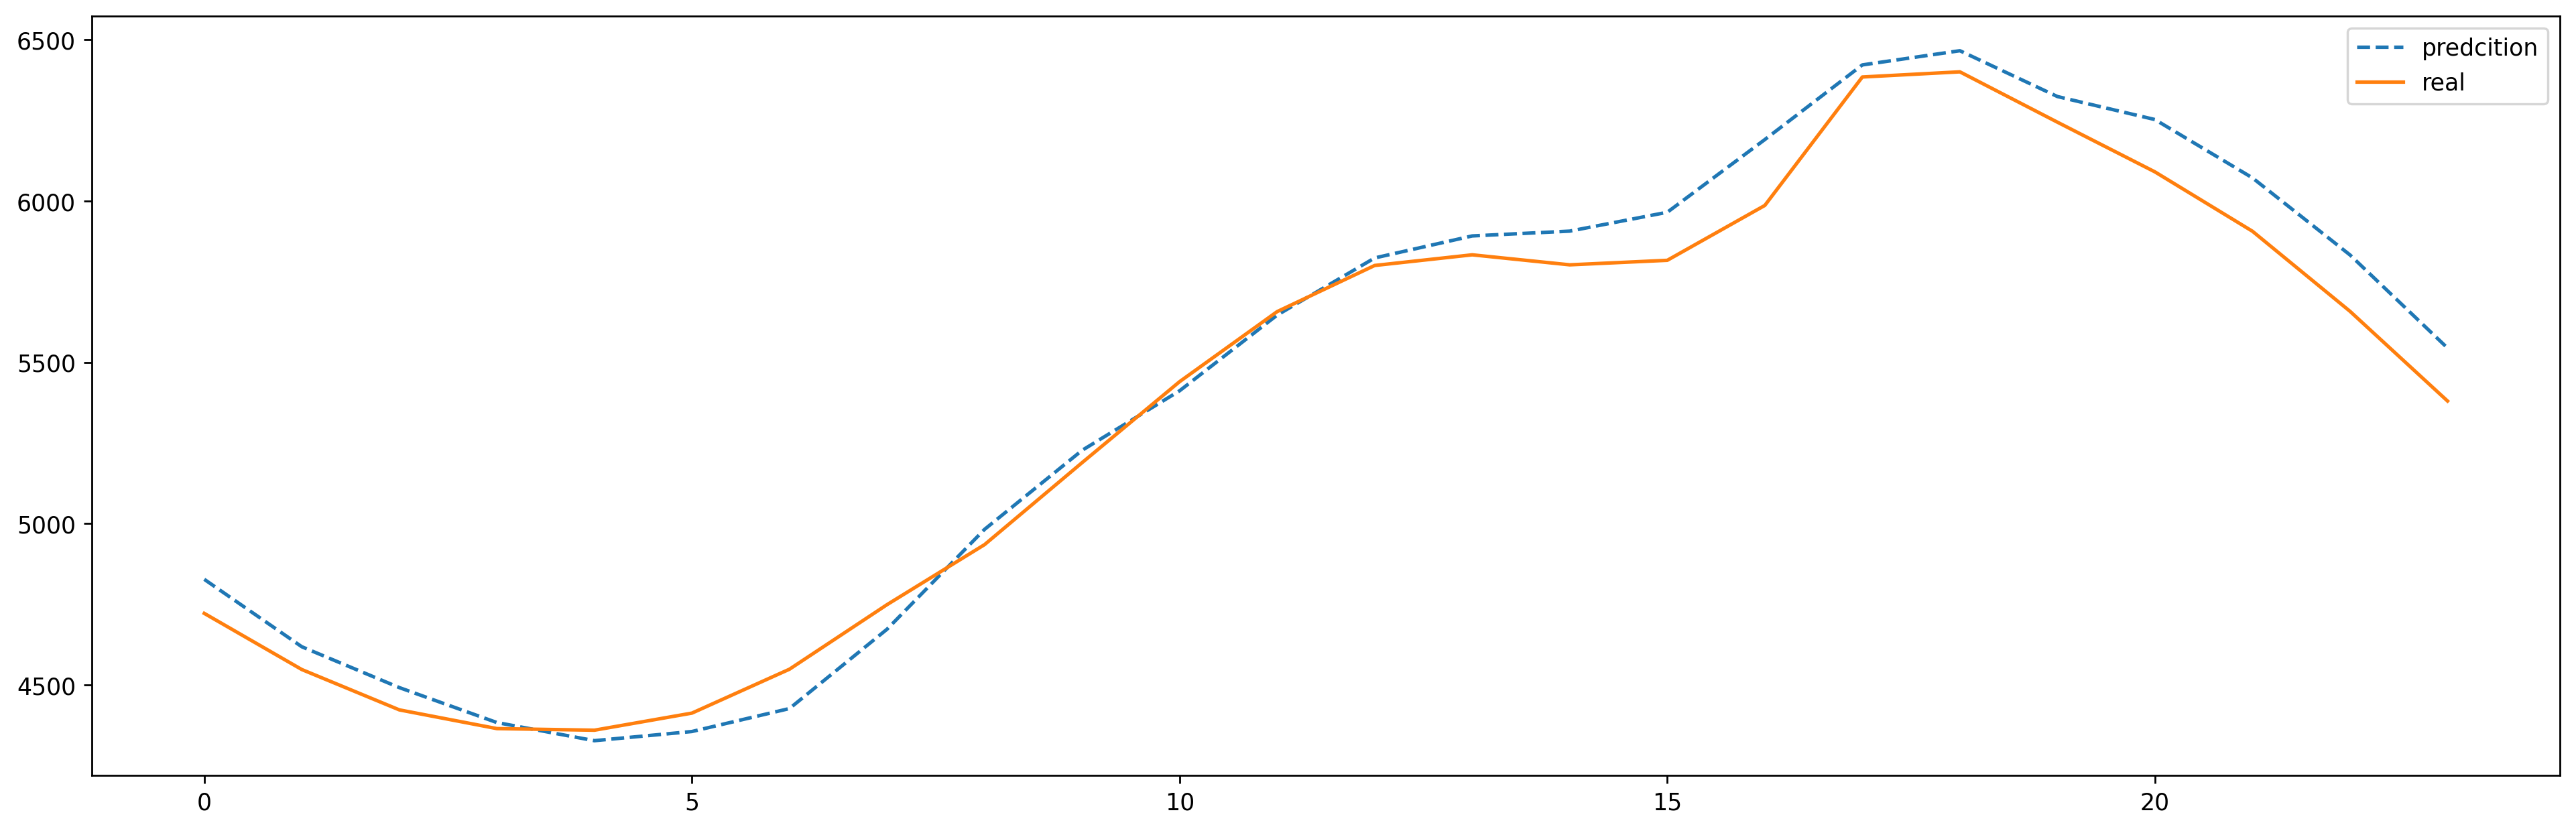

In [32]:
figure(figsize=(19, 6), dpi=250)

#select the day to forecast
day=1

dates = range(len(prediction_descaled))
plt.plot(dates[0:24], prediction_descaled[day*24] , "--", label="predcition")
plt.plot(dates[0:24], values_descaled[day*24], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();